# Convolutional Neural Network for Speech Command Recognition

## Preliminaries

### Imports

In [24]:
import os
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
print(tf.__version__)



%matplotlib inline

import sys
sys.path.append("../..")
from E4525_ML.TFClassifier import TFClassifier
from E4525_ML.multiclass_logistic import LogisticGDClassifier

from E4525_ML import plots

1.11.0


In [2]:
#
from tensorflow.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
seed=456
np.random.seed(seed)

### Data

In [5]:
raw_data_dir="../..raw/speech_commands"

In [6]:
data_dir=r"../../data/speech_commands"

In [7]:
file=open(data_dir+"/mfcc.p","rb")
features_all,labels_all=pickle.load(file)

In [8]:
features,features_test,labels,labels_test=train_test_split(features_all,labels_all,test_size=0.1)
print(features.shape,len(features_test))

(58248, 20, 44) 6473


In [9]:
features_train,features_val,labels_train,labels_val=train_test_split(features,labels,test_size=0.1)
print(features_train.shape,len(features_val))

(52423, 20, 44) 5825


In [25]:
classes=np.unique(labels_train)
nK=len(classes)
print(classes)
print(nK)

['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']
30


## Logistic Classifier

In [11]:
sk_model=LogisticRegression(C=1e30,solver="newton-cg",multi_class="multinomial")
sk_model.fit(features_train.reshape(len(features_train),-1),labels_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
Y_pred=sk_model.predict(features_train.reshape(len(features_train),-1))
np.mean(Y_pred==labels_train)

0.5509032294985026

In [13]:
Y_pred=sk_model.predict(features_val.reshape(len(features_val),-1))
np.mean(Y_pred==labels_val)

0.4061802575107296

##  Neural Network Model

In [61]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self,frequency,use_val=False):
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            #print(logs.keys())
            train_loss=logs["loss"]
            train_acc=logs["acc"]
            print(f"\t{epoch}: TRAIN Loss {train_loss:.4f},  Accuracy {train_acc:.4f}",end=self.separator)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_acc=logs["val_acc"]
                print(f"VAL Loss {val_loss:.4f}, Accuracy {val_acc:.4f}")

In [141]:
encoder=LabelEncoder()
Y_train=encoder.fit_transform(labels_train)
Y_val=encoder.transform(labels_val)
Y_test=encoder.transform(labels_test)
Y=encoder.transform(labels)

In [169]:
model = keras.Sequential([
    keras.layers.Reshape( (20, 44, 1),input_shape=(20,44)),
   
    keras.layers.Conv2D(32, (1, 2), activation='relu',padding="same"),
    keras.layers.Dropout(0.),  
    keras.layers.MaxPooling2D(pool_size=(1, 2)),
    
    
    
    keras.layers.Conv2D(64, (2, 2), activation='relu',padding="same"),
    keras.layers.Dropout(0.), 
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, (1, 2), activation='relu',padding="same"),
    keras.layers.Dropout(0.),
    keras.layers.MaxPooling2D(pool_size=(1, 2)),
    
    
    keras.layers.Conv2D(128, (1, 2), activation='relu',padding="same"),  
    keras.layers.Dropout(0.),  
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(128, (2, 2), activation='relu',padding="same"),
    keras.layers.Dropout(0.5),  
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
   
   
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation=K.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(256, activation=K.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(nK, activation=K.softmax)
])

In [170]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001,decay=1e-6),#tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [171]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 20, 44, 1)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 20, 44, 32)        96        
_________________________________________________________________
dropout_73 (Dropout)         (None, 20, 44, 32)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 20, 22, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 20, 22, 64)        8256      
_________________________________________________________________
dropout_74 (Dropout)         (None, 20, 22, 64)        0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 10, 11, 64)        0         
__________

In [172]:
model.fit(features_train, Y_train, epochs=500,batch_size=100,validation_data=(features_val,Y_val),
          verbose=0,callbacks=[ReportCallback(10,True)])

	0: TRAIN Loss 3.4606,  Accuracy 0.0743 || VAL Loss 2.8999, Accuracy 0.2180
	10: TRAIN Loss 0.9936,  Accuracy 0.6974 || VAL Loss 0.7076, Accuracy 0.7902
	20: TRAIN Loss 0.6624,  Accuracy 0.7969 || VAL Loss 0.5034, Accuracy 0.8503
	30: TRAIN Loss 0.5139,  Accuracy 0.8390 || VAL Loss 0.4215, Accuracy 0.8731
	40: TRAIN Loss 0.4158,  Accuracy 0.8679 || VAL Loss 0.3884, Accuracy 0.8829
	50: TRAIN Loss 0.3571,  Accuracy 0.8861 || VAL Loss 0.3655, Accuracy 0.8889
	60: TRAIN Loss 0.3056,  Accuracy 0.9027 || VAL Loss 0.3544, Accuracy 0.8939
	70: TRAIN Loss 0.2694,  Accuracy 0.9131 || VAL Loss 0.3357, Accuracy 0.9003
	80: TRAIN Loss 0.2387,  Accuracy 0.9220 || VAL Loss 0.3342, Accuracy 0.9025
	90: TRAIN Loss 0.2114,  Accuracy 0.9302 || VAL Loss 0.3391, Accuracy 0.9011
	100: TRAIN Loss 0.1965,  Accuracy 0.9371 || VAL Loss 0.3514, Accuracy 0.8989
	110: TRAIN Loss 0.1766,  Accuracy 0.9416 || VAL Loss 0.3391, Accuracy 0.9052
	120: TRAIN Loss 0.1609,  Accuracy 0.9470 || VAL Loss 0.3357, Accuracy 0.90

### Test Model

In [173]:
model.fit(features, Y, epochs=500,batch_size=100,validation_data=(features_test,Y_test),
          verbose=0,callbacks=[ReportCallback(10,True)])

	0: TRAIN Loss 0.1131,  Accuracy 0.9728 || VAL Loss 0.3788, Accuracy 0.9099
	10: TRAIN Loss 0.0770,  Accuracy 0.9773 || VAL Loss 0.3625, Accuracy 0.9123
	20: TRAIN Loss 0.0637,  Accuracy 0.9802 || VAL Loss 0.3759, Accuracy 0.9160
	30: TRAIN Loss 0.0587,  Accuracy 0.9808 || VAL Loss 0.3711, Accuracy 0.9164
	40: TRAIN Loss 0.0565,  Accuracy 0.9819 || VAL Loss 0.3801, Accuracy 0.9150
	50: TRAIN Loss 0.0561,  Accuracy 0.9821 || VAL Loss 0.3843, Accuracy 0.9160
	60: TRAIN Loss 0.0522,  Accuracy 0.9833 || VAL Loss 0.3875, Accuracy 0.9192
	70: TRAIN Loss 0.0511,  Accuracy 0.9836 || VAL Loss 0.3866, Accuracy 0.9144
	80: TRAIN Loss 0.0507,  Accuracy 0.9844 || VAL Loss 0.4024, Accuracy 0.9150
	90: TRAIN Loss 0.0476,  Accuracy 0.9845 || VAL Loss 0.3975, Accuracy 0.9152
	100: TRAIN Loss 0.0461,  Accuracy 0.9851 || VAL Loss 0.3969, Accuracy 0.9140
	110: TRAIN Loss 0.0468,  Accuracy 0.9850 || VAL Loss 0.4056, Accuracy 0.9143
	120: TRAIN Loss 0.0436,  Accuracy 0.9858 || VAL Loss 0.4066, Accuracy 0.91

In [174]:
classes=np.unique(labels_test)

In [186]:
Y_pred=np.argmax(model.predict(features_test),axis=1)
labels_pred=encoder.inverse_transform(Y_pred)
labels_pred

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['right', 'three', 'zero', ..., 'stop', 'yes', 'no'], dtype='<U6')

Confusion matrix, without normalization
[[153   3   0   0   1   0   1   0   0   0   0   1   0   0   0   0   1   0
    1   0   0   0   0   0   0   1   0   0   0   0]
 [  2 177   0   1   0   0   0   1   1   0   0   1   1   1   0   0   2   0
    0   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0 157   1   2   0   0   0   0   0   0   1   0   1   0   1   0   0
    0   0   0   1   1   0   1   0   1   1   0   0]
 [  0   1   0 148   3   1   1   2   5   0   0   0   0   0   2   0   0   0
    0   0   0   0   3   0   0   0   0   0   0   0]
 [  1   1   0   5 230   0   2   0  10   0   0   1   0   2   4   0   0   0
    0   0   0   0   0   0   1   0   0   3   0   0]
 [  3   1   0   1   1 220   0   0   1   0   0   1   0   0   1   0   1   0
    2   0   0   0   0   3   1   2   0   0   0   1]
 [  0   0   0   2   0   0 210   0   0   0   0   0   0   0   0   0   5   0
    2   0   0   0   1   1   0   1   0   2   1   0]
 [  0   0   0   0   0   0   2 203   0   0   0   0   0   0   0   2   3   2
    1   0  

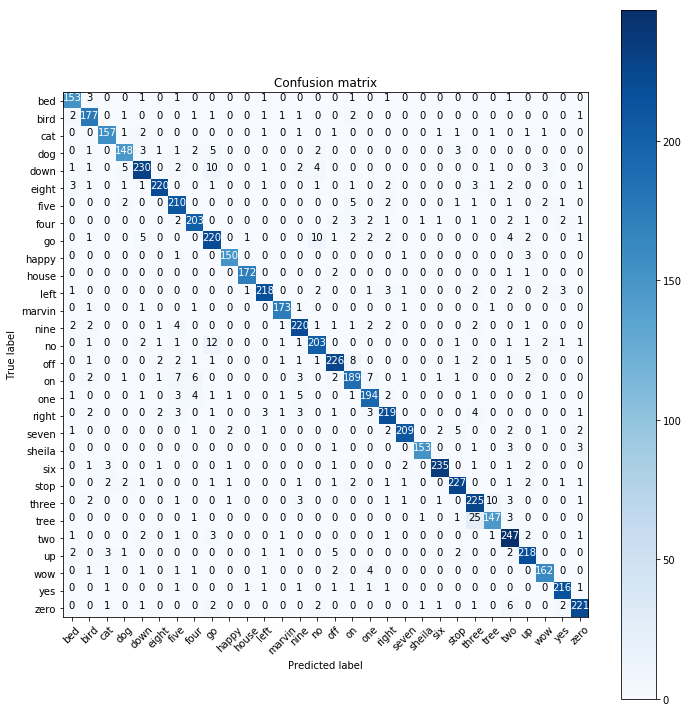

In [187]:
plt.figure(figsize=(10,10))
cnf_matrix = metrics.confusion_matrix(labels_test, labels_pred)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

## Other networds I tried

In [ ]:
network=CNN_SpeechCommands(
   conv_layers=[
            ([2,4],16,0.),       
           ([2,4],32,0.4)
        ],
    dense_layers=[
        (128,0.),
        (128,0.4)
        ]
    ,K=K) # 88%

In [ ]:
network=CNN_SpeechCommands(
   conv_layers=[
            ([1,2],8,0.),   
            ([2,2],16,0.),   
            ([1,2],32,0.),   
           ([2,2],64,0.4)
        ],
    dense_layers=[
        (128,0.),
        (128,0.4)
        ]
    ,K=K) # 88.4%

In [ ]:
network=CNN_SpeechCommands(
   conv_layers=[
            ([1,2],16,0.),   
            ([2,2],32,0.),   
            ([1,2],64,0.),   
           ([2,2],128,0.0),
           ([2,1],128,0.5)
        ],
    dense_layers=[
        (256,0.),
        (256,0.5)
        ]
    ,K=K) # 91%, 200,000 steps